## Exercise 2    || TIME SERIES PREDICTIVE MODEL & EVALUATION

 ### Kaosik Rajakumaran | 402662     |              Introduction to Data Science

------------------
Build a model which predicts the average daily price of the next day.

Apply a time series back testing procedure!  
(two third of the data for training and one third for evaluation of the model)

--------------------

------------------

Step 0: Prepare Data set

• Attention for this the data set has to be cleaned and normalized to daily data!

• The entire analysis has to be performed on 100 gas stations

• Choose the 100 gas stations with the longest time history

• Ensure that all stations have all identical time horizon and steps 
(open and close hour identical for all 100 stations, take 7:00 to 20:00). 

. Align all data before calculating the average price of the day to ensure comparable daily prices!

• ensure a perfect data set, clean outlier


------------------------

# Step 0: Prepare Data set ------------------------------------------

In [55]:
#Data Importing and cleaning

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
from datetime import datetime as dt 
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit

In [56]:
stationPrices = pd.read_csv('example_sprit_cut_prices.csv', delimiter=';')
stationInfos =pd.read_csv('example_sprit_cut_station.csv', delimiter=';')

In [57]:
def removeOutlier(stationPrices):
    #avoid repetitions-----------------
    stationPrices.drop_duplicates(inplace=True) 
    stationInfos.drop_duplicates(inplace=True)

    #remove outlieres eg: negative values-------------------
    zerosE5 = stationPrices[stationPrices["E5"]<=900] 
    stationPrices.drop(zerosE5.index,axis=0,inplace=True)
    zerosE10 = stationPrices[stationPrices["E10"]<=900]
    stationPrices.drop(zerosE10.index,axis=0,inplace=True)
    zerosDiesel = stationPrices[stationPrices["DIESEL"]<=900]
    stationPrices.drop(zerosDiesel.index,axis=0,inplace=True)

    #remove above 1999
    stationPrices = stationPrices[stationPrices['E5']<1999]
    stationPrices = stationPrices[stationPrices['E10']<1999]
    stationPrices = stationPrices[stationPrices['DIESEL']<1999]
    
    return stationPrices

removeOutlier(stationPrices)
stationPrices.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED
0,01bf5a06-4248-43a5-9524-56123fa3ab2f,1589,1549,1389,2014-10-02 05:22:01.000000,21
1,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1369,2014-10-02 05:26:01.000000,21
2,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1359,2014-10-02 09:06:01.000000,1
3,01bf5a06-4248-43a5-9524-56123fa3ab2f,1539,1499,1339,2014-10-03 12:14:01.000000,21
4,01bf5a06-4248-43a5-9524-56123fa3ab2f,1529,1489,1329,2014-10-03 14:14:01.000000,21


In [58]:
def getStrpTime(x):
   
    x = x.split(".")[0]
    y = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return y

def getIdenticalTimeHorizon(x):
  
    x = x.split(".")[0]
    y = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    yIdenticalTimeHorizon = y.hour > 6 and y.hour < 21
    return yIdenticalTimeHorizon

def getDayValues(x):    

    y = x.split(" ")[0]
    return y

In [59]:
firstDate_AllStations = stationPrices.groupby("STID")["DATE_CHANGED"].min() #first date of all stations
main_FirstDate = firstDate_AllStations.sort_values().head(1).values[0] #oldest date - one main smallest date in the file
main_FirstDateCorrected = (getStrpTime(main_FirstDate) + timedelta(days=1))
main_FirstDateCorrected = main_FirstDateCorrected.replace(minute=00, hour=7, second=00)#corrrect time

print("Start Date and Time: " + str(main_FirstDateCorrected))

Start Date and Time: 2014-06-09 07:00:00


In [60]:
idsIn_MainFirstDate = stationPrices.loc[stationPrices["DATE_CHANGED"].apply(getStrpTime) <= main_FirstDateCorrected]["STID"].values #station-ids that have Main_firstDate

# open and close hour identical for all 100 stations, take 7:00 to 20:00
stationPrices_identical = stationPrices.loc[stationPrices["STID"].isin(idsIn_MainFirstDate)] #all columns from idsInMainFirstDate
stationPrices_identical =  stationPrices_identical.loc[stationPrices["DATE_CHANGED"].apply(getIdenticalTimeHorizon)] #all ids in this range

In [61]:
#Choose the 100 gas stations with the longest time history + in range: 7:00 to 20:00
Stations_100_ID = stationPrices_identical.groupby("STID")["DATE_CHANGED"].size().sort_values().tail(100).index.values 
Stations_100 = stationPrices_identical.loc[stationPrices_identical["STID"].isin(Stations_100_ID)] # Get all columns (E5,E10,Diesel) corresponding to those ids

In [62]:
Stations_100["DATE_CHANGED"] = Stations_100["DATE_CHANGED"].apply(getDayValues) # Convert time stamp to day only ---- 
Stations_100_group = Stations_100.sort_values(by="DATE_CHANGED").groupby("STID")# Get time sorted ID groups

C:\Users\RAK7SI\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [63]:
# Find Start Date, End Date & totalDays
startDate_allStations = Stations_100.groupby("STID")["DATE_CHANGED"].min()
startDate = startDate_allStations.sort_values().head(1).values[0]
startDate = dt.strptime(startDate, "%Y-%m-%d")  

endDate_allStations = Stations_100.groupby("STID")["DATE_CHANGED"].max()
endDate = endDate_allStations.sort_values().head(1).values[0]
endDate = dt.strptime(endDate, "%Y-%m-%d")  + timedelta(days=1)

totalDays = (endDate - startDate).days + 1 #total number of days

listDays = []
for y in range(0, totalDays):
    listDays.append(str((startDate + timedelta(days=1*y)).date()))

print("Start Date (from) = " + str(startDate) , "||  End Date (till) = " + str(endDate))
print("Total Days = " + str(totalDays))

Start Date (from) = 2014-06-08 00:00:00 ||  End Date (till) = 2015-09-28 00:00:00
Total Days = 478


### Dataframes for Average Prices



In [64]:
# Station-ID's in rows  | #Dates in columns (here first as NAN)
e5Data = pd.DataFrame(columns=listDays) 
e5Data.insert(loc=0, column='ID', value=Stations_100_group.groups.keys())

e10Data = pd.DataFrame(columns=listDays)
e10Data.insert(loc=0, column='ID', value=Stations_100_group.groups.keys())

dieselData = pd.DataFrame(columns=listDays)
dieselData.insert(loc=0, column='ID', value=Stations_100_group.groups.keys())

#Append dates columns with average prices
for key, item in Stations_100_group:
    
    keysID = Stations_100_group.get_group(key) #get group keys    
    datesValues = keysID["DATE_CHANGED"].isin(listDays) #get dates values
    datesValues_loc = keysID.loc[datesValues]
    
    averagePrices = datesValues_loc.groupby("DATE_CHANGED")[["E5", "E10", "DIESEL"]].mean() # Get daily mean prices
    averagePrices_idx = averagePrices.index  # Get all dates of mean prices
    
    #replace NAN with available real Data
    e5IdxC = e5Data.loc[e5Data['ID'] == key].columns.isin(averagePrices_idx) # Get boolean index of those dates that were measured for the current id
    e10IdxC = e10Data.loc[e10Data['ID'] == key].columns.isin(averagePrices_idx) 
    dieselIdxC = e10Data.loc[dieselData['ID'] == key].columns.isin(averagePrices_idx) 

    e5Data.loc[e5Data['ID'] == key, e5IdxC] = averagePrices["E5"].values       
    e10Data.loc[e10Data['ID'] == key, e10IdxC] = averagePrices["E10"].values
    dieselData.loc[e10Data['ID'] == key, dieselIdxC] = averagePrices["DIESEL"].values

print (' \n ______________________ AVERAGE PRICES - START DATES (Sample Station No: 100)_________________________________ \n ')
print (averagePrices.head(3))
print (' \n ______________________ AVERAGE PRICES - END DATES (Sample Station No: 100) _________________________________ \n ')
print (averagePrices.tail(3))

 
 ______________________ AVERAGE PRICES - START DATES (Sample Station No: 100)_________________________________ 
 
                  E5     E10  DIESEL
DATE_CHANGED                        
2014-06-08    1624.0  1584.0  1414.0
2014-06-09    1569.0  1529.0  1374.0
2014-06-10    1566.5  1526.5  1381.5
 
 ______________________ AVERAGE PRICES - END DATES (Sample Station No: 100) _________________________________ 
 
                       E5          E10       DIESEL
DATE_CHANGED                                       
2015-09-26    1346.777778  1326.777778  1137.888889
2015-09-27    1332.636364  1312.636364  1123.545455
2015-09-28    1339.000000  1319.000000  1125.666667


In [65]:
#replace NAN's with forward fill
e5Data = e5Data.fillna(method = "ffill")
e10Data = e10Data.fillna(method = "ffill")
dieselData = dieselData.fillna(method = "ffill")
e5Data.head()

,ID,2014-06-08,2014-06-09,2014-06-10,2014-06-11,2014-06-12,2014-06-13,2014-06-14,2014-06-15,2014-06-16,...,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28
0,01a94df2-5e6e-4a4a-b1f5-e2612e25a62f,1609.0,1614.0,1612.333333,1605.666667,1609.000000,1699.000000,1699.0,1699.0,1699.000000,...,1375.666667,1359.000000,1345.666667,1347.333333,1341.222222,1337.571429,1336.500000,1364.000000,1350.666667,1356.500000
1,033bce61-7584-45e7-94dd-952fd0b4899c,1604.0,1669.0,1599.000000,1602.333333,1605.666667,1699.000000,1699.0,1699.0,1639.000000,...,1350.111111,1340.666667,1315.666667,1320.250000,1326.500000,1301.000000,1320.428571,1335.666667,1341.000000,1327.333333
2,061716a5-f4a6-4983-a36e-8ef1e8ce17e0,1519.0,1594.0,1599.000000,1609.000000,1689.000000,1699.000000,1699.0,1699.0,1699.000000,...,1359.000000,1354.714286,1352.750000,1345.666667,1333.285714,1329.000000,1335.250000,1337.750000,1347.571429,1347.888889
3,07a543ee-7e3c-4620-a03d-fe60d0d3ba71,1594.0,1669.0,1595.666667,1602.333333,1599.000000,1615.666667,1639.0,1699.0,1622.333333,...,1347.333333,1365.666667,1337.000000,1350.428571,1349.000000,1360.250000,1349.000000,1356.500000,1336.500000,1345.666667
4,07e07bdc-6b0d-461a-b4b5-88a680f5b229,1604.0,1604.0,1595.666667,1609.000000,1599.000000,1699.000000,1639.0,1699.0,1622.333333,...,1365.666667,1357.000000,1349.000000,1349.000000,1350.666667,1314.000000,1345.250000,1310.666667,1353.000000,1324.714286


 


# Step 1: Start with small data set and develop a simple reference model 

Step 1: start with small (3 stations) data set and develop a simple reference model

• Extract a small good data set you can start with

• Start with a trivial model (reference model), use a simple moving average

• Use the Time Series Cross Validation (TimeSeriesSplitt) of scikit-learn

• Check and visualize the results

• Use an appropriate metric for the forecast error: mean absolute deviation (MAD)

and mean absolute percentage error (MAPE)

• Do a visualization of the predicted output (time series)

## 1.1 Moving Average Model (ARMA)

In [66]:
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [67]:
import numpy as np

# Function for Evaluation Metrics MAPE MAD
def getMeanValues(x):
    "Function to get average values"
    y = sum(x)/len(x)
    return y

def getMAD(Y, Yhat):   
    MADvalue = np.sum(np.abs(( Yhat - Y.mean())))/Yhat.shape[0]
    return MADvalue

def getMAPE(Y, Yhat):   
    MAPEvalue = 100*np.sum(np.abs((Y - Yhat)/Y))/Yhat.shape[0]
    return MAPEvalue

In [68]:
def plotARMA(x, y, yhat, heading):
    
    xRange = list(range(len(x)))
    yRange = list(range(len(x), len(x) + len(y)))
    
    plt.figure(figsize=(15,5))
    plt.plot(xRange, x.values, 'g', label="Trained Data")
    plt.plot(yRange, y.values, 'mo', label="Actual")
    plt.plot([xRange[-1], yRange[0]], [x.values[-1], y.values], 'm:')
    plt.plot(yRange, yhat, 'ro', label="Predicted Values")
    plt.plot([xRange[-1], yRange[0]], [x.values[-1], yhat], 'r:')
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Price (€)')
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f €'))
    plt.legend()
    plt.grid()
    plt.title(heading)
    plt.show()   

# Unit Testing of 3 Functions

In [69]:
import unittest
import pandas as pd
import numpy as np
class MyTest(unittest.TestCase): 
        
    def test_getMAD(self):
        x1 = np.array([2,2,2,2])
        x2 = np.array([3,3,3,3])
        x3 = np.array([5,5,5,5])
        self.assertEqual(getMAD(x1,x2), 1)
        self.assertEqual(getMAD(x1,x3), 3)
        self.assertEqual(getMAD(x2,x3), 2)
        
    def test_getMAPE(self):
        x1 = np.array([2,2,2,2])
        x2 = np.array([3,3,3,3])
        x3 = np.array([5,5,5,5])
        self.assertEqual(getMAPE(x1,x2), 50.0)
        self.assertEqual(getMAPE(x1,x3), 150.0)
        self.assertEqual(getMAPE(x2,x3), 66.66666666666666)
        
    def test_getMeanValues(self):
        x1 = np.array([2,4,6,8,10])
        x2 = np.array([10,20,30,40,50])
        x3 = np.array([1,1,1,1,1])
        self.assertEqual(getMeanValues(x1), 6.0)
        self.assertEqual(getMeanValues(x2), 30.0)
        self.assertEqual(getMeanValues(x3), 1.0)   
        
        
unittest.main(argv=[''], verbosity=2, exit=False)

test_getMAD (__main__.MyTest) ... ok
test_getMAPE (__main__.MyTest) ... ok
test_getMeanValues (__main__.MyTest) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.003s

OK


## 1.1.1 FOR E5

In [70]:
e5Data_3 = e5Data.drop('ID', axis=1).head(3) 
tscv = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e5MAD = []
e5MAPE = []
e5MSE = []

In [71]:
for train_index, test_index in tscv.split(e5Data_3.loc[0]):
    
    for index, station_e5 in e5Data_3.iterrows(): #loop for each station
        
        e5X = station_e5[train_index] #load train        
        e5Y = station_e5[test_index][:1] #load test max_test_data_size        
                
        Mdl = ARMA(e5X.values, order=(0, 4)) #Auto regression Moving Average
        MdlFit = Mdl.fit(start_params=(0, 0, 0, 0, 0))
        e5Yhat = MdlFit.predict(start=len(e5X), end=(len(e5X) + len(e5Y) - 1)) #next day everytime
        
        #evaluation Metrics
        e5MSE.append(mean_squared_error(e5Y, e5Yhat))        
        e5MAD.append(getMAD(e5Y.values, e5Yhat)) 
        e5MAPE.append(getMAPE(e5Y.values, e5Yhat))


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

In [72]:
mean_e5MSE = getMeanValues(e5MSE)/1000
mean_e5MAD = getMeanValues(e5MAD)/1000
mean_e5MAPE = getMeanValues(e5MAPE)

print("____________________Evaluation Metrics for E5 with ARMA Model___________________")

print("MSE: %1.2f €"  % mean_e5MSE)
print("MAD: %1.4f €"  % mean_e5MAD)
print("MAPE: %1.2f %%"  % mean_e5MAPE)

____________________Evaluation Metrics for E5 with ARMA Model___________________
MSE: 0.89 €
MAD: 0.0230 €
MAPE: 1.59 %


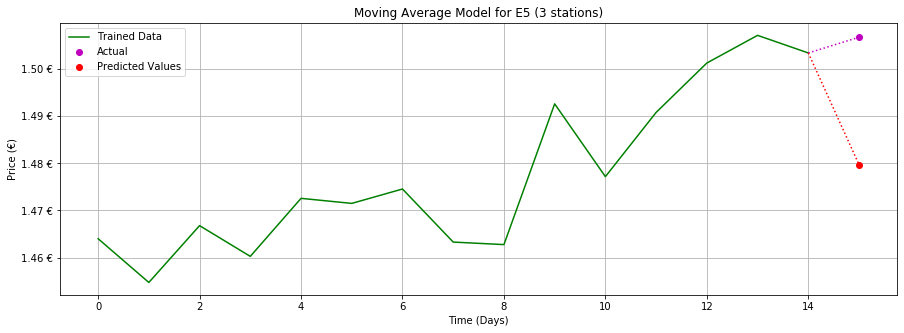

In [73]:
#Do a visualization of the predicted output (time series)
plotARMA(e5X/1000, e5Y/1000, e5Yhat/1000, "Moving Average Model for E5 (3 stations)")

## 1.1.2 FOR E10

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

____________________Evaluation Metrics for e10 with ARMA Model___________________
MSE: 0.70 €
MAD: 0.0209 €
MAPE: 1.43 %


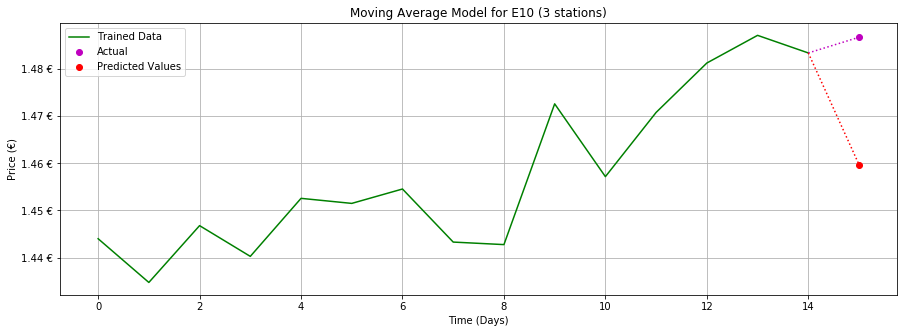

In [74]:
e10Data_3 = e10Data.drop('ID', axis=1).head(3) 
tscv = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e10MAD = []
e10MAPE = []
e10MSE = []

for train_index, test_index in tscv.split(e10Data_3.loc[0]):
    
    for index, station_e10 in e10Data_3.iterrows(): #loop for each station
        
        e10X = station_e10[train_index] #load train
        e10Y = station_e10[test_index][:1] #load test max_test_data_size
                
        Mdl = ARMA(e10X.values, order=(0, 4)) #Auto regression Moving Average
        MdlFit = Mdl.fit(start_params=(0, 0, 0, 0, 0))
        e10Yhat = MdlFit.predict(start=len(e10X), end=(len(e10X) + len(e10Y) - 1)) #next day everytime
        
        #evaluation Metrics
        e10MSE.append(mean_squared_error(e10Y, e10Yhat))        
        e10MAD.append(getMAD(e10Y.values, e10Yhat)) 
        e10MAPE.append(getMAPE(e10Y.values, e10Yhat))
        
        
        
mean_e10MSE = getMeanValues(e10MSE)/1000
mean_e10MAD = getMeanValues(e10MAD)/1000
mean_e10MAPE = getMeanValues(e10MAPE)

print("____________________Evaluation Metrics for e10 with ARMA Model___________________")

print("MSE: %1.2f €"  % mean_e10MSE) 
print("MAD: %1.4f €"  % mean_e10MAD)
print("MAPE: %1.2f %%"  % mean_e10MAPE)


plotARMA(e10X/1000, e10Y/1000, e10Yhat/1000, "Moving Average Model for E10 (3 stations)")

## 1.1.3 FOR DIESEL

In [75]:
dieselData_3 = dieselData.drop('ID', axis=1).head(3) 
tscv = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
dieselMAD = []
dieselMAPE = []
dieselMSE = []

for train_index, test_index in tscv.split(dieselData_3.loc[0]):
    
    for index, station_diesel in dieselData_3.iterrows(): #loop for each station
        
        dieselX = station_diesel[train_index] #load train
        dieselY = station_diesel[test_index][:1] #load test max_test_data_size
                
        Mdl = ARMA(dieselX.values, order=(0, 4)) #Auto regression Moving Average
        MdlFit = Mdl.fit(start_params=(0, 0, 0, 0, 0))
        dieselYhat = MdlFit.predict(start=len(dieselX), end=(len(dieselX) + len(dieselY) - 1)) #next day everytime
        
        #evaluation Metrics
        dieselMSE.append(mean_squared_error(dieselY, dieselYhat))        
        dieselMAD.append(getMAD(dieselY.values, dieselYhat)) 
        dieselMAPE.append(getMAPE(dieselY.values, dieselYhat))
        
                


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

____________________Evaluation Metrics for diesel with ARMA Model___________________
MSE: 0.86 €
MAD: 0.0187 €
MAPE: 1.57 %


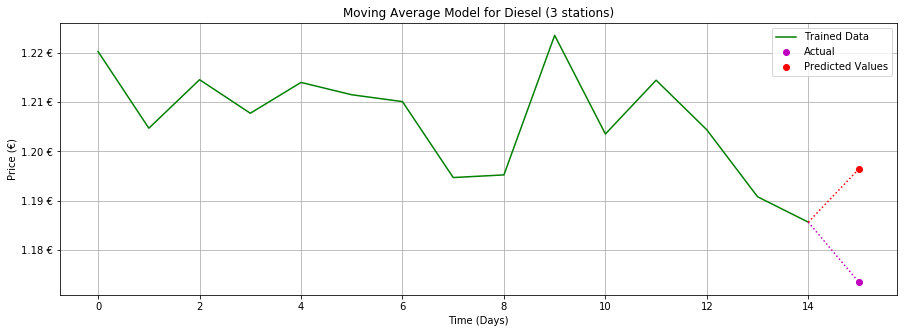

In [76]:
mean_dieselMSE = getMeanValues(dieselMSE)/1000
mean_dieselMAD = getMeanValues(dieselMAD)/1000
mean_dieselMAPE = getMeanValues(dieselMAPE)

print("____________________Evaluation Metrics for diesel with ARMA Model___________________")

print("MSE: %1.2f €"  % mean_dieselMSE)
print("MAD: %1.4f €"  % mean_dieselMAD)
print("MAPE: %1.2f %%"  % mean_dieselMAPE)


plotARMA(dieselX/1000, dieselY/1000, dieselYhat/1000, "Moving Average Model for Diesel (3 stations)")

# Step 2: go with a more complicated model

• Use a more elaborated time series modeling.

• Use the Facebook Prophet package

• Compare the prediction result against the trivial reference model

In [77]:
def plotProphet(x, y, yhat, heading):  

    
    xRange = list(range(len(x)))
    yRange = list(range(len(x), len(x) + len(y)))
    
    plt.figure(figsize=(15,5))
    plt.plot(xRange, x["y"].values, 'g', label="Trainined Data")
    plt.plot(yRange, y["y"].values, 'mo', label="Actual")
    plt.plot([xRange[-1], yRange[0]], [x["y"].values[-1], y["y"].values], 'm:')
    plt.plot(yRange, yhat.tail(len(y))["yhat"], 'ro', label="Predicted")
    plt.plot([xRange[-1], yRange[0]], [x["y"].values[-1], yhat.tail(len(y))["yhat"]], 'r:')
    
    plt.xlabel('Time (Days)')
    plt.ylabel('Price (€)')
    plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f €'))
    plt.legend()
    plt.title(heading)
    plt.grid()
    plt.show()
    

# 2.1 FOR E5

In [78]:
from fbprophet import Prophet

tscvProphet = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e5MAD_fb = []
e5MAPE_fb = []
e5MSE_fb = []

for train_index, test_index in tscvProphet.split(e5Data_3.loc[0]):   
    
    for index, V in e5Data_3.iterrows():
        
        e5df = pd.DataFrame(np.array([V.index.values, V.values/1000]).T, columns=['ds', 'y'])
        e5X = e5df.iloc[train_index]
        e5Y = e5df.iloc[test_index].head(1)
        
        Mdl = Prophet()
        Mdl.fit(e5X)
        future_df = Mdl.make_future_dataframe(periods=1)
        e5Yhat = Mdl.predict(future_df)        
        
        e5MSE_fb.append(mean_squared_error(e5Y["y"].values, e5Yhat.tail(1)["yhat"].values))
        e5MAD_fb.append(getMAD(e5Y["y"].values, e5Yhat.tail(1)["yhat"].values))
        e5MAPE_fb.append(getMAPE(e5Y["y"].values, e5Yhat.tail(1)["yhat"].values))

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

____________________Evaluation Metrics for E5 with FB PROPHET Model___________________
MSE: 0.00 €
MAD: 0.0144 €
MAPE: 1.00 %


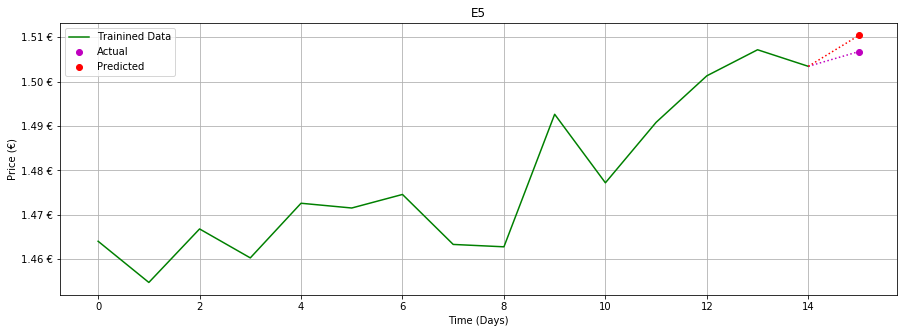

In [79]:
mean_e5MSE_fb = getMeanValues(e5MSE_fb)
mean_e5MAD_fb = getMeanValues(e5MAD_fb)
mean_e5MAPE_fb = getMeanValues(e5MAPE_fb)

print("____________________Evaluation Metrics for E5 with FB PROPHET Model___________________")

print("MSE: %1.2f €"  % mean_e5MSE_fb)
print("MAD: %1.4f €"  % mean_e5MAD_fb)
print("MAPE: %1.2f %%"  % mean_e5MAPE_fb)


plotProphet(e5X, e5Y, e5Yhat, "E5")

# 2.2 For E10

In [80]:
tscvProphet = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e10MAD_fb = []
e10MAPE_fb = []
e10MSE_fb = []

for train_index, test_index in tscvProphet.split(e10Data_3.loc[0]):   
    
    for index, V in e10Data_3.iterrows():
        
        e10df = pd.DataFrame(np.array([V.index.values, V.values/1000]).T, columns=['ds', 'y'])
        e10X = e10df.iloc[train_index]
        e10Y = e10df.iloc[test_index].head(1)
        
        Mdl = Prophet()
        Mdl.fit(e10X)
        future_df = Mdl.make_future_dataframe(periods=1)
        e10Yhat = Mdl.predict(future_df)        
        
        e10MSE_fb.append(mean_squared_error(e10Y["y"].values, e10Yhat.tail(1)["yhat"].values))
        e10MAD_fb.append(getMAD(e10Y["y"].values, e10Yhat.tail(1)["yhat"].values))
        e10MAPE_fb.append(getMAPE(e10Y["y"].values, e10Yhat.tail(1)["yhat"].values))

        
mean_e10MSE_fb = getMeanValues(e10MSE_fb)
mean_e10MAD_fb = getMeanValues(e10MAD_fb)
mean_e10MAPE_fb = getMeanValues(e10MAPE_fb)



C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

____________________Evaluation Metrics for e10 with FB PROPHET Model___________________
MSE: 0.00 €
MAD: 0.0139 €
MAPE: 0.98 %


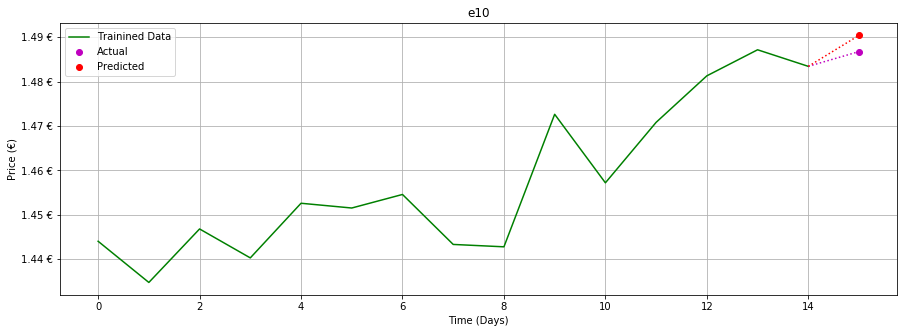

In [81]:
print("____________________Evaluation Metrics for e10 with FB PROPHET Model___________________")

print("MSE: %1.2f €"  % mean_e10MSE_fb)
print("MAD: %1.4f €"  % mean_e10MAD_fb)
print("MAPE: %1.2f %%"  % mean_e10MAPE_fb)

plotProphet(e10X, e10Y, e10Yhat, "e10")

# 2.3 FOR DIESEL

In [82]:
tscvProphet = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
dieselMAD_fb = []
dieselMAPE_fb = []
dieselMSE_fb = []

for train_index, test_index in tscvProphet.split(dieselData_3.loc[0]):   
    
    for index, V in dieselData_3.iterrows():
        
        dieseldf = pd.DataFrame(np.array([V.index.values, V.values/1000]).T, columns=['ds', 'y'])
        dieselX = dieseldf.iloc[train_index]
        dieselY = dieseldf.iloc[test_index].head(1)
        
        Mdl = Prophet()
        Mdl.fit(dieselX)
        future_df = Mdl.make_future_dataframe(periods=1)
        dieselYhat = Mdl.predict(future_df)        
        
        dieselMSE_fb.append(mean_squared_error(dieselY["y"].values, dieselYhat.tail(1)["yhat"].values))
        dieselMAD_fb.append(getMAD(dieselY["y"].values, dieselYhat.tail(1)["yhat"].values))
        dieselMAPE_fb.append(getMAPE(dieselY["y"].values, dieselYhat.tail(1)["yhat"].values))

        


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

____________________Evaluation Metrics for diesel with FB PROPHET Model___________________
MSE: 0.00 €
MAD: 0.0157 €
MAPE: 1.27 %


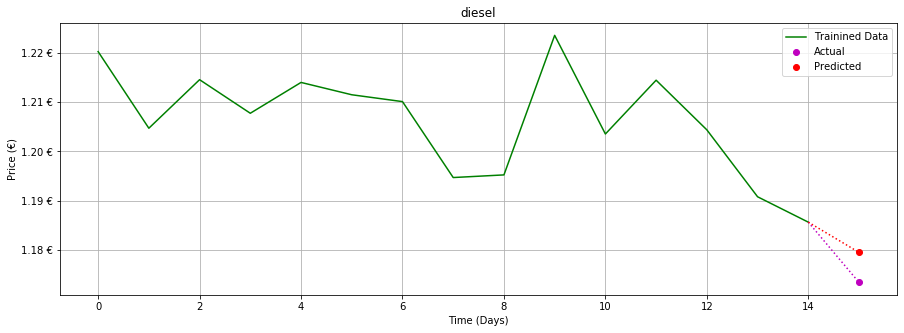

In [83]:
mean_dieselMSE_fb = getMeanValues(dieselMSE_fb)
mean_dieselMAD_fb = getMeanValues(dieselMAD_fb)
mean_dieselMAPE_fb = getMeanValues(dieselMAPE_fb)

print("____________________Evaluation Metrics for diesel with FB PROPHET Model___________________")

print("MSE: %1.2f €"  % mean_dieselMSE_fb)
print("MAD: %1.4f €"  % mean_dieselMAD_fb)
print("MAPE: %1.2f %%"  % mean_dieselMAPE_fb)

plotProphet(dieselX, dieselY, dieselYhat, "diesel")

# Step 3: For Full 100 Data set and Compare

# 3.1 ARMA for 100 stations

## 3.1.1 FOR E5

In [84]:
e5Data_100 = e5Data.drop('ID', axis=1).head(100) 
tscv = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e5MAD100 = []
e5MAPE100 = []
e5MSE100 = []

for train_index, test_index in tscv.split(e5Data_100.loc[0]):
    
    for index, station_e5 in e5Data_100.iterrows(): #loop for each station
        
        e5X = station_e5[train_index] #load train        
        e5Y = station_e5[test_index][:1] #load test max_test_data_size        
                
        Mdl = ARMA(e5X.values, order=(0, 4)) #Auto regression Moving Average
        MdlFit = Mdl.fit(start_params=(0, 0, 0, 0, 0))
        e5Yhat = MdlFit.predict(start=len(e5X), end=(len(e5X) + len(e5Y) - 1)) #next day everytime
        
        #evaluation Metrics
        e5MSE100.append(mean_squared_error(e5Y, e5Yhat))        
        e5MAD100.append(getMAD(e5Y.values, e5Yhat)) 
        e5MAPE100.append(getMAPE(e5Y.values, e5Yhat))


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

____________________Evaluation Metrics for E5 with ARMA Model___________________
MSE: 1.30 €
MAD: 0.0266 €
MAPE: 1.83 %


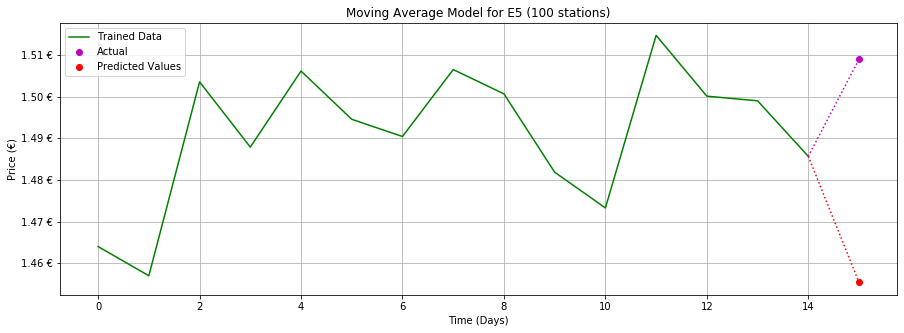

In [85]:
mean_e5MSE100 = getMeanValues(e5MSE100)/1000
mean_e5MAD100 = getMeanValues(e5MAD100)/1000
mean_e5MAPE100 = getMeanValues(e5MAPE100)

print("____________________Evaluation Metrics for E5 with ARMA Model___________________")

print("MSE: %3.2f €"  % mean_e5MSE100)
print("MAD: %1.4f €"  % mean_e5MAD100)
print("MAPE: %3.2f %%"  % mean_e5MAPE100)

plotARMA(e5X/1000, e5Y/1000, e5Yhat/1000, "Moving Average Model for E5 (100 stations)")

## 3.1.2 FOR E10

In [86]:
e10Data_100 = e10Data.drop('ID', axis=1).head(100) 
tscv = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e10MAD100 = []
e10MAPE100 = []
e10MSE100 = []

for train_index, test_index in tscv.split(e10Data_100.loc[0]):
    
    for index, station_e10 in e10Data_100.iterrows(): #loop for each station
        
        e10X = station_e10[train_index] #load train        
        e10Y = station_e10[test_index][:1] #load test max_test_data_size        
                
        Mdl = ARMA(e10X.values, order=(0, 4)) #Auto regression Moving Average
        MdlFit = Mdl.fit(start_params=(0, 0, 0, 0, 0))
        e10Yhat = MdlFit.predict(start=len(e10X), end=(len(e10X) + len(e10Y) - 1)) #next day everytime
        
        #evaluation Metrics
        e10MSE100.append(mean_squared_error(e10Y, e10Yhat))        
        e10MAD100.append(getMAD(e10Y.values, e10Yhat)) 
        e10MAPE100.append(getMAPE(e10Y.values, e10Yhat))
        


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\mode

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

____________________Evaluation Metrics for E10 with ARMA Model___________________
MSE: 1.13 €
MAD: 0.0245 €
MAPE: 1.72 %


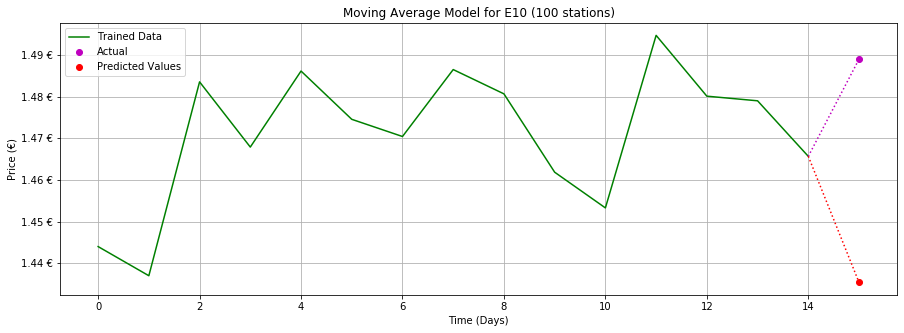

In [87]:
mean_e10MSE100 = getMeanValues(e10MSE100)/1000
mean_e10MAD100 = getMeanValues(e10MAD100)/1000
mean_e10MAPE100 = getMeanValues(e10MAPE100)

print("____________________Evaluation Metrics for E10 with ARMA Model___________________")

print("MSE: %1.2f €"  % mean_e10MSE100)
print("MAD: %1.4f €"  % mean_e10MAD100)
print("MAPE: %3.2f %%"  % mean_e10MAPE100)

plotARMA(e10X/1000, e10Y/1000, e10Yhat/1000, "Moving Average Model for E10 (100 stations)")

## 3.1.3 FOR DIESEL

In [88]:
dieselData_100 = dieselData.drop('ID', axis=1).head(100) 
tscv = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
dieselMAD100 = []
dieselMAPE100 = []
dieselMSE100 = []

for train_index, test_index in tscv.split(dieselData_100.loc[0]):
    
    for index, station_diesel in dieselData_100.iterrows(): #loop for each station
        
        dieselX = station_diesel[train_index] #load train        
        dieselY = station_diesel[test_index][:1] #load test max_test_data_size        
                
        Mdl = ARMA(dieselX.values, order=(0, 4)) #Auto regression Moving Average
        MdlFit = Mdl.fit(start_params=(0, 0, 0, 0, 0))
        dieselYhat = MdlFit.predict(start=len(dieselX), end=(len(dieselX) + len(dieselY) - 1)) #next day everytime
        
        #evaluation Metrics
        dieselMSE100.append(mean_squared_error(dieselY, dieselYhat))        
        dieselMAD100.append(getMAD(dieselY.values, dieselYhat)) 
        dieselMAPE100.append(getMAPE(dieselY.values, dieselYhat))       


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\l

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packa

____________________Evaluation Metrics for diesel with ARMA Model___________________
MSE: 1.48 €
MAD: 0.0285 €
MAPE: 2.29 %


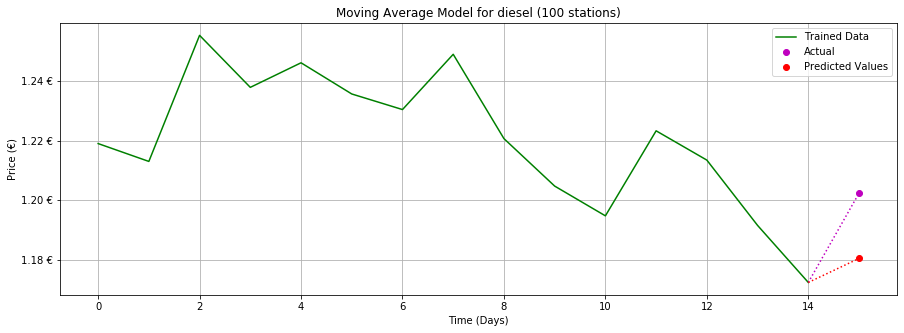

In [89]:
mean_dieselMSE100 = getMeanValues(dieselMSE100)/1000
mean_dieselMAD100 = getMeanValues(dieselMAD100)/1000
mean_dieselMAPE100 = getMeanValues(dieselMAPE100)

print("____________________Evaluation Metrics for diesel with ARMA Model___________________")

print("MSE: %3.2f €"  % mean_dieselMSE100)
print("MAD: %1.4f €"  % mean_dieselMAD100)
print("MAPE: %3.2f %%"  % mean_dieselMAPE100)

plotARMA(dieselX/1000, dieselY/1000, dieselYhat/1000, "Moving Average Model for diesel (100 stations)")

# 3.2 FB Probhet for 100 Stations

# 3.2.1 FOR E5

In [90]:
tscvProphet100 = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e5MAD_fb100 = []
e5MAPE_fb100 = []
e5MSE_fb100 = []

for train_index, test_index in tscvProphet100.split(e5Data_100.loc[0]):   
    
    for index, V in e5Data_100.iterrows():
        
        e5df = pd.DataFrame(np.array([V.index.values, V.values/1000]).T, columns=['ds', 'y'])
        e5X = e5df.iloc[train_index]
        e5Y = e5df.iloc[test_index].head(1)
        
        Mdl = Prophet()
        Mdl.fit(e5X)
        future_df = Mdl.make_future_dataframe(periods=1)
        e5Yhat = Mdl.predict(future_df)        
        
        e5MSE_fb100.append(mean_squared_error(e5Y["y"].values, e5Yhat.tail(1)["yhat"].values))
        e5MAD_fb100.append(getMAD(e5Y["y"].values, e5Yhat.tail(1)["yhat"].values))
        e5MAPE_fb100.append(getMAPE(e5Y["y"].values, e5Yhat.tail(1)["yhat"].values))        


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

____________________Evaluation Metrics for e5 with FB PROPHET Model (100 Stations)___________________
MSE: 0.00 €
MAD: 0.0166 €
MAPE: 1.14 %


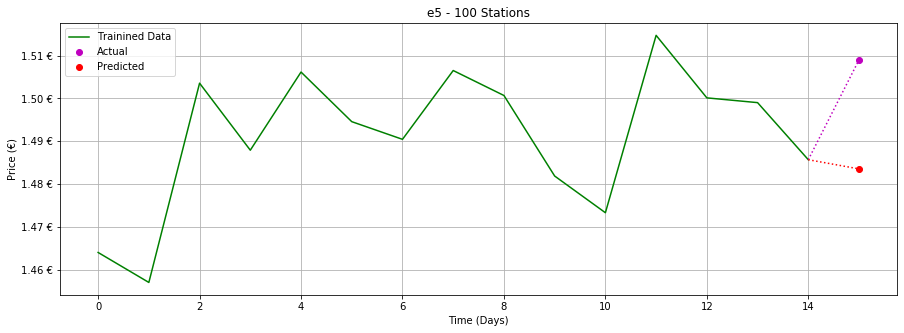

In [91]:
mean_e5MSE_fb100 = getMeanValues(e5MSE_fb100)
mean_e5MAD_fb100 = getMeanValues(e5MAD_fb100)
mean_e5MAPE_fb100 = getMeanValues(e5MAPE_fb100)

print("____________________Evaluation Metrics for e5 with FB PROPHET Model (100 Stations)___________________")

print("MSE: %1.2f €"  % mean_e5MSE_fb100)
print("MAD: %1.4f €"  % mean_e5MAD_fb100)
print("MAPE: %1.2f %%"  % mean_e5MAPE_fb100)

plotProphet(e5X, e5Y, e5Yhat, "e5 - 100 Stations")

# 3.2.2 FOR E10

In [92]:
tscvProphet100 = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
e10MAD_fb100 = []
e10MAPE_fb100 = []
e10MSE_fb100 = []

for train_index, test_index in tscvProphet100.split(e10Data_100.loc[0]):   
    
    for index, V in e10Data_100.iterrows():
        
        e10df = pd.DataFrame(np.array([V.index.values, V.values/1000]).T, columns=['ds', 'y'])
        e10X = e10df.iloc[train_index]
        e10Y = e10df.iloc[test_index].head(1)
        
        Mdl = Prophet()
        Mdl.fit(e10X)
        future_df = Mdl.make_future_dataframe(periods=1)
        e10Yhat = Mdl.predict(future_df)        
        
        e10MSE_fb100.append(mean_squared_error(e10Y["y"].values, e10Yhat.tail(1)["yhat"].values))
        e10MAD_fb100.append(getMAD(e10Y["y"].values, e10Yhat.tail(1)["yhat"].values))
        e10MAPE_fb100.append(getMAPE(e10Y["y"].values, e10Yhat.tail(1)["yhat"].values))      


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

____________________Evaluation Metrics for e10 with FB PROPHET Model (100 Stations)___________________
MSE: 0.00 €
MAD: 0.0165 €
MAPE: 1.15 %


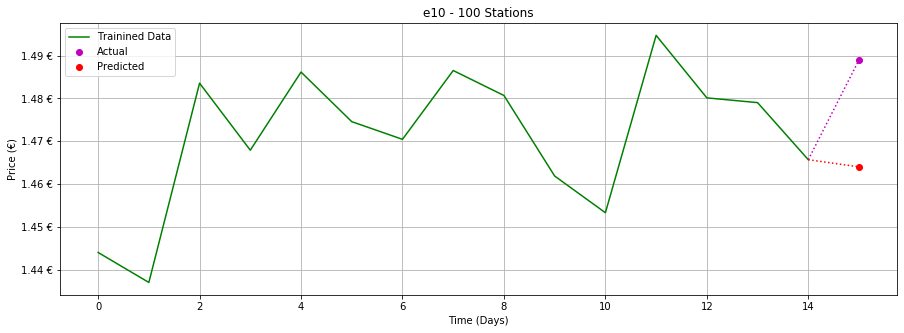

In [93]:
mean_e10MSE_fb100 = getMeanValues(e10MSE_fb100)
mean_e10MAD_fb100 = getMeanValues(e10MAD_fb100)
mean_e10MAPE_fb100 = getMeanValues(e10MAPE_fb100)

print("____________________Evaluation Metrics for e10 with FB PROPHET Model (100 Stations)___________________")

print("MSE: %1.2f €"  % mean_e10MSE_fb100)
print("MAD: %1.4f €"  % mean_e10MAD_fb100)
print("MAPE: %1.2f %%"  % mean_e10MAPE_fb100)

plotProphet(e10X, e10Y, e10Yhat, "e10 - 100 Stations")

## 3.2.3 FOR DIESEL

In [94]:
tscvProphet100 = TimeSeriesSplit(max_train_size=15, n_splits=5)

#Evaulation Metrics - MAD, MSE MAPE (list)
dieselMAD_fb100 = []
dieselMAPE_fb100 = []
dieselMSE_fb100 = []

for train_index, test_index in tscvProphet100.split(dieselData_100.loc[0]):   
    
    for index, V in dieselData_100.iterrows():
        
        dieseldf = pd.DataFrame(np.array([V.index.values, V.values/1000]).T, columns=['ds', 'y'])
        dieselX = dieseldf.iloc[train_index]
        dieselY = dieseldf.iloc[test_index].head(1)
        
        Mdl = Prophet()
        Mdl.fit(dieselX)
        future_df = Mdl.make_future_dataframe(periods=1)
        dieselYhat = Mdl.predict(future_df)        
        
        dieselMSE_fb100.append(mean_squared_error(dieselY["y"].values, dieselYhat.tail(1)["yhat"].values))
        dieselMAD_fb100.append(getMAD(dieselY["y"].values, dieselYhat.tail(1)["yhat"].values))
        dieselMAPE_fb100.append(getMAPE(dieselY["y"].values, dieselYhat.tail(1)["yhat"].values))       


C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\fbprophet\forecaster.py:794: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 11.0.
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
C:\Users\RAK7SI\AppData\Local\conda\conda\envs\myenv_kaosik_01\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.

____________________Evaluation Metrics for diesel with FB PROPHET Model (100 Stations)___________________
MSE: 0.00 €
MAD: 0.0153 €
MAPE: 1.23 %


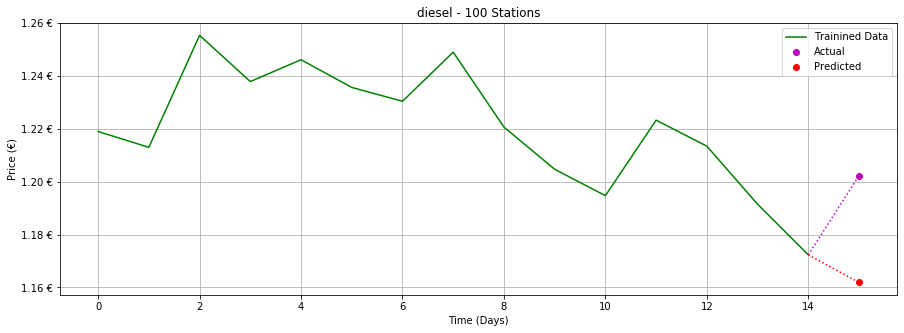

In [95]:
mean_dieselMSE_fb100 = getMeanValues(dieselMSE_fb100)
mean_dieselMAD_fb100 = getMeanValues(dieselMAD_fb100)
mean_dieselMAPE_fb100 = getMeanValues(dieselMAPE_fb100)

print("____________________Evaluation Metrics for diesel with FB PROPHET Model (100 Stations)___________________")

print("MSE: %1.2f €"  % mean_dieselMSE_fb100)
print("MAD: %1.4f €"  % mean_dieselMAD_fb100)
print("MAPE: %1.2f %%"  % mean_dieselMAPE_fb100)

plotProphet(dieselX, dieselY, dieselYhat, "diesel - 100 Stations")

# Summary | Comparison

After Comparing the evaluation metrics - MAD & MAPE, between ARMA & FB Prophet, 

    it can be noticed that prediction values from FB Probhet model are more accurate & Consistent.

For 100 stations, for all fuel types,

    the MAPE is around 2% for ARMA, where as around 1% for FB Prophet.
    the MAD is around 0.023€ for ARMA, where as around 0.015 for FB Prophet.

Comparison between Results from 3 stations and 100 stations:

    Here, it can be noticed that Fb Probhet model is roughly prediciting consistent results, irrespective of available data size.

    Where as, in ARMA Model, there is an considerable difference in evaluation metrics when compared between results from 3 and 100 stations.

